## FEN Generator

The goal of the project is to build a model able to generate [Forsyth–Edwards Notation
](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) (FEN) description based on a schematic image of a chess board.

I will be using Kaggle [Chess positions](https://www.kaggle.com/koryakinp/chess-positions) dataset of generated images of **28 styles of chess boards** and **32 styles of chess pieces** totaling **896 board/piece style combinations**

In [2]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
import os
import re

In [3]:
%matplotlib inline

Configuring GPU to allow memory growth to avoid OOM kernel crashes 

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


Define datasets for data location

In [5]:
DATA_DIR = Path('data/chess')
TEMP_DIR = Path('temp/chess')
TRAIN_DATA_DIR = DATA_DIR/"train"
TEST_DATA_DIR = DATA_DIR/"test"
DOWNLOAD_DATA = False

In [6]:
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
if DOWNLOAD_DATA:
    !kaggle datasets download -d koryakinp/chess-positions --unzip -p {DATA_DIR}

Define couple helper classes for easier data manipulation

In [9]:
def ceate_df(data_path):
    file_paths = [data_path/fn for fn in os.listdir(data_path)]
    tuples = [(path.stem, str(path)) for path in file_paths]
    return pd.DataFrame(list(tuples), columns=["fen", "path"])

In [10]:
df = ceate_df(TRAIN_DATA_DIR)

In [12]:
df.shape

(80000, 2)

In [13]:
df.head()

fen  \
0            8-3pPKp1-7p-8-1N4k1-7P-8-7R   
1    KR3k2-8-1P4Pp-3P4-7P-2Nb4-2b4n-4B2N   
2    7n-N5B1-2p5-2KN4-n3r3-N2BrkpB-4r3-8   
3               1r6-8-1R6-6k1-B7-8-2K5-8   
4  nN4B1-1b1B4-r7-8-5PN1-KPk5-3P4-B1B3R1   

                                                path  
0  data/chess/train/8-3pPKp1-7p-8-1N4k1-7P-8-7R.jpeg  
1  data/chess/train/KR3k2-8-1P4Pp-3P4-7P-2Nb4-2b4...  
2  data/chess/train/7n-N5B1-2p5-2KN4-n3r3-N2BrkpB...  
3     data/chess/train/1r6-8-1R6-6k1-B7-8-2K5-8.jpeg  
4  data/chess/train/nN4B1-1b1B4-r7-8-5PN1-KPk5-3P...

In [14]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
chess_pieses = 'prbnkqPRBNKQ'
SQUARE_SIZE = 71
IMG_DIM = SQUARE_SIZE * 8
IMG_DIMS = (IMG_DIM, IMG_DIM)

In [16]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)
   
    for char in fen:
        if(char in '12345678'):
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = chess_pieses.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output.astype(int)

In [17]:
def process_image(image):
    image = tf.image.resize(image, IMG_DIMS)
    
    image = tf.expand_dims(image, 0)
    patches = tf.image.extract_patches(
        images=image, 
        sizes=[1, SQUARE_SIZE, SQUARE_SIZE, 1], 
        strides=[1, SQUARE_SIZE, SQUARE_SIZE, 1], 
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
        
    patches = tf.squeeze(patches, axis=0)
   
    return tf.reshape(patches, [64, SQUARE_SIZE, SQUARE_SIZE, 3])

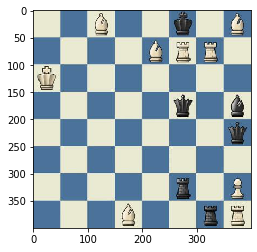

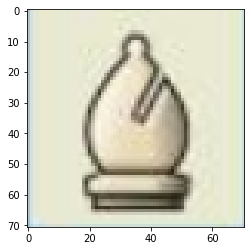

In [143]:
image_file = train_data['path'].values[0]
image_file = tf.io.read_file(image_file)

image = tf.image.decode_jpeg(image_file, channels=3)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)

plt.imshow(image)
plt.show()

patches = process_image(image)
patch1 = patches[2]

plt.imshow(patch1)
plt.show()

In [21]:
def image_parse(filepath, preprocess_fn, img_dims):
    image_file = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = preprocess_fn(image)
    return image

In [22]:
def prepare_ds(df, batch_size, parse_fn, shuffle=False, augment_fn=None, num_parallel_calls=-1):
    dataset_length = len(df)
    
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS)
    labels = [onehot_from_fen(fen) for fen in df.fen]
    
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32)).unbatch()
    
    dataset = (
        tf.data.Dataset.from_tensor_slices(df.path.values)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    ).unbatch()
    
    ds = tf.data.Dataset.zip((dataset, label_ds))
    
    if shuffle:
        ds = ds.shuffle(dataset_length)
    
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, dataset_length, batch_size

In [23]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    train_data,
    batch_size=16,
    shuffle=True,
    parse_fn=image_parse, 
    augment_fn=process_image
)

In [24]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    train_data,
    batch_size=16,
    shuffle=False,
    parse_fn=image_parse,
    augment_fn=process_image
)

In [26]:
def make_model(
    n_classes,
    input_shape,
    dropout=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    
    return keras.Model(inputs=base_model.inputs, outputs=x)

Sanity check of datasets before starting the training

In [27]:
print(train_dataset)
print(val_dataset)

<PrefetchDataset shapes: ((None, 71, 71, 3), (None, 13)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 71, 71, 3), (None, 13)), types: (tf.float32, tf.float32)>


In [28]:
def train_model(model, optimizer, lr, epochs):
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.categorical_crossentropy,
        metrics=[
            keras.metrics.categorical_accuracy,  
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [29]:
model = make_model(
    n_classes=13,
    input_shape=(71, 71, 3),
    dropout=0.3,
    l1=3e-6,
    l2=3e-5,
)

In [37]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [30]:
history = train_model(
    model=model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=50,
)

Epoch 1/50


W0822 10:10:38.064909 140070580492096 deprecation.py:323] From /home/martynas/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


4000/4000 [==============================] - 362s 91ms/step - loss: 0.2355 - categorical_accuracy: 0.9671 - val_loss: 0.2114 - val_categorical_accuracy: 0.9645
Epoch 2/50
4000/4000 [==============================] - 340s 85ms/step - loss: 0.0240 - categorical_accuracy: 0.9960 - val_loss: 0.0059 - val_categorical_accuracy: 0.9998
Epoch 3/50
4000/4000 [==============================] - 341s 85ms/step - loss: 0.0147 - categorical_accuracy: 0.9975 - val_loss: 0.0278 - val_categorical_accuracy: 0.9961
Epoch 4/50
4000/4000 [==============================] - 340s 85ms/step - loss: 0.0125 - categorical_accuracy: 0.9986 - val_loss: 0.0204 - val_categorical_accuracy: 0.9967
Epoch 5/50
4000/4000 [==============================] - 340s 85ms/step - loss: 0.0137 - categorical_accuracy: 0.9982 - val_loss: 0.0052 - val_categorical_accuracy: 0.9990
Epoch 6/50
4000/4000 [==============================] - 341s 85ms/step - loss: 0.0078 - categorical_accuracy: 0.9992 - val_loss: 0.2702 - val_categorical_ac

4000/4000 [==============================] - 341s 85ms/step - loss: 1.7361e-04 - categorical_accuracy: 1.0000 - val_loss: 0.7731 - val_categorical_accuracy: 0.9455
Epoch 48/50
4000/4000 [==============================] - 341s 85ms/step - loss: 1.6904e-04 - categorical_accuracy: 1.0000 - val_loss: 0.6369 - val_categorical_accuracy: 0.9507
Epoch 49/50
4000/4000 [==============================] - 341s 85ms/step - loss: 1.7166e-04 - categorical_accuracy: 1.0000 - val_loss: 0.7821 - val_categorical_accuracy: 0.9455
Epoch 50/50
4000/4000 [==============================] - 340s 85ms/step - loss: 1.6802e-04 - categorical_accuracy: 1.0000 - val_loss: 0.8465 - val_categorical_accuracy: 0.9449


In [31]:
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [32]:
model.save_weights(best_model_weights_path)
with open(best_model_arch_path, "w") as f:
    f.write(model.to_json())

In [33]:
def plot_history(history, contains: str, skip=0):
    df = pd.DataFrame(history.history)
    df[list(df.filter(regex=contains))].iloc[skip:].plot()

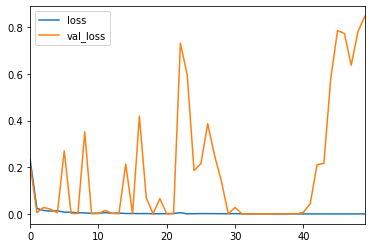

In [35]:
plot_history(history, "loss", 0)

In [39]:
test_data = ceate_df(TEST_DATA_DIR)

In [40]:
def prepare_test_ds(df, batch_size, parse_fn, augment_fn=None, num_parallel_calls=-1):
    dataset_length = len(df)
    
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS)
    
    ds = (
        tf.data.Dataset.from_tensor_slices(df.path.values)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    
    print(ds)
    
    ds = ds.repeat()
    ds = ds.prefetch(1)
    return ds, dataset_length, batch_size

In [47]:
test_dataset, test_dataset_length, test_batch_size = prepare_test_ds(
    test_data,
    batch_size=1,
    parse_fn=image_parse, 
    augment_fn=process_image
)

<ParallelMapDataset shapes: (64, 71, 71, 3), types: tf.float32>


In [48]:
prediction = model.predict(test_dataset, steps=test_dataset_length/test_batch_size)

In [52]:
predictions = prediction.argmax(axis=1).reshape(-1,8,8)

In [53]:
def fen_from_prediction(prediction):
    output = ''
    for j in range(8):
        for i in range(8):
            if(prediction[j][i] == 12):
                output += ' '
            else:
                output += chess_pieses[prediction[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [77]:
fens_from_predictions = np.array([fen_from_prediction(pred) for pred in predictions])
fens_from_file_name = test_data.fen.values

Evaluate the model

In [78]:
(fens_from_predictions == fens_from_file_name).astype(float).mean()

0.85595

In [96]:
final = test_data.join(pd.DataFrame(fens_from_predictions)).drop('path', axis=1)
final.columns = ['fen', 'fen_predicted']

In [118]:
def count_errors(row):
    fen1 = row['fen']
    fen2 = row['fen_predicted']
    diff = []
    
    if fen1 == fen2:
        return "OK"
    
    if len(fen1) != len(fen2):
        return 'len do not match'
    
    for idx, val in enumerate(fen1):
        if val == fen2[idx]:
            diff += "_"
        else:
            diff += fen2[idx]
        
    return "".join(diff)

In [120]:
final['delta'] = final.apply(lambda row: count_errors(row), axis = 1)

In [127]:
final.drop(final[final['delta'] == 'OK'].index, inplace=True)

In [131]:
final.head()

fen  \
2                   1K3r2-3Q4-8-7p-7k-1n6-8-8   
9     5k2-2r5-4n3-1K1b1qr1-4p3-3N2N1-N2P4-Nq6   
33       1q6-8-q5k1-1r4bP-4Bpb1-r5bn-3N1K2-7B   
38  7R-2r2K2-2R3P1-p2p4-1R3q2-1b3k2-8-2R1B1B1   
43        4b3-4P3-K2b1n2-5kN1-2B5-3r4-8-1R4R1   

                                        fen_predicted             delta  
2   1K1k1r1k-k1kQk1k1-1k1k1k1k-k1k1k1kp-1k1k1k1k-k...  len do not match  
9   1k1k1k1k-k1r1k1k1-1k1knp1k-kKkbkqr1-1k1kpk1k-k...  len do not match  
33  1q1k1p1k-k1p5-q5k1-krp3bP-1p1pBpbp-r1p3bn-3N1K...  len do not match  
38  1k1k1k1R-k1r1kKk1-1pRk1pPk-p1kpk1k1-1R1k1q1k-k...  len do not match  
43  1k1pbp1k-p3P3-Kp1b1n1k-k1p1pkN1-1pBp1p1k-k1prk...  len do not match

In [132]:
def display_with_predicted_fen(test):
    row = test_data.loc[[test]]
    
    file_path = row.path[test]
    image_file = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image_file, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    processed = process_image(image)
    
    actual_fen = file_path.split("/")[-1][:-5]
    pred = model.predict(processed).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_prediction(pred[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual:      {actual_fen}\nPrediction: {fen}")
    plt.show()

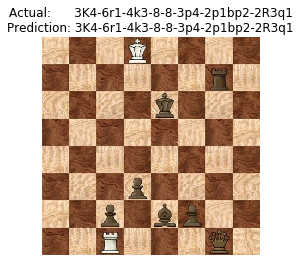

In [137]:
display_with_predicted_fen(5)

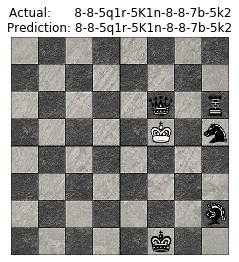

In [58]:
display_with_predicted_fen(10)

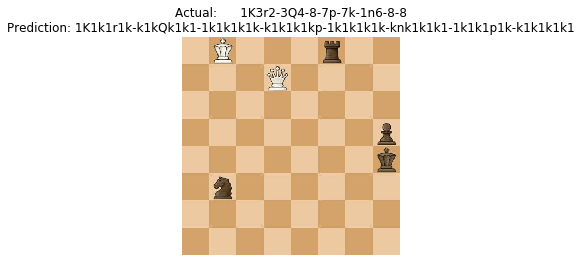

In [138]:
display_with_predicted_fen(2)

## Visualise activations

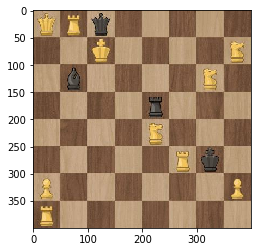

In [156]:
image_file = test_data['path'].values[15]
image_file = tf.io.read_file(image_file)

image = tf.image.decode_jpeg(image_file, channels=3)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)

plt.imshow(image)
plt.show()

image = process_image(image)

In [157]:
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in model.layers[:20]]
# Creates a model that will return these outputs, given the model input
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) 

In [158]:
activations = activation_model.predict(image) # Returns a list of five Numpy arrays: one array per layer activation

/home/martynas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


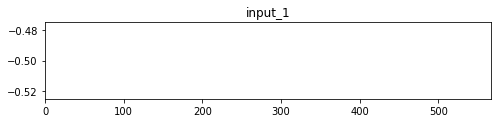

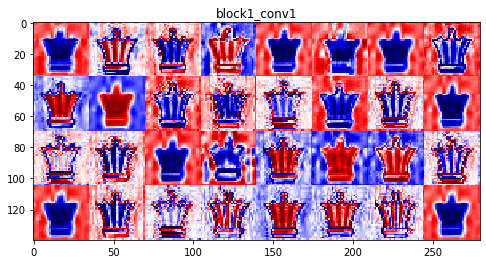

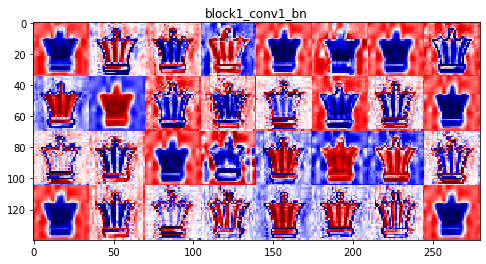

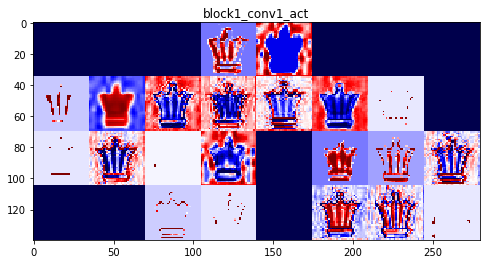

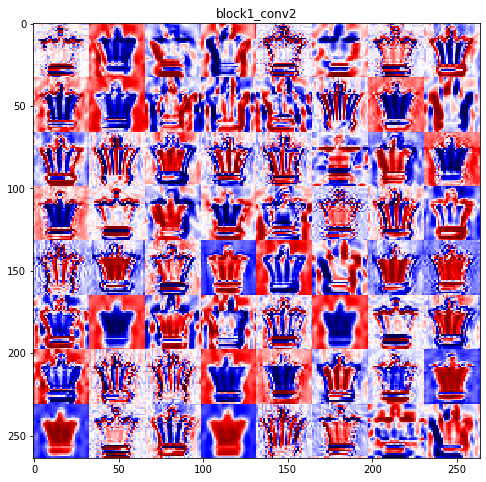

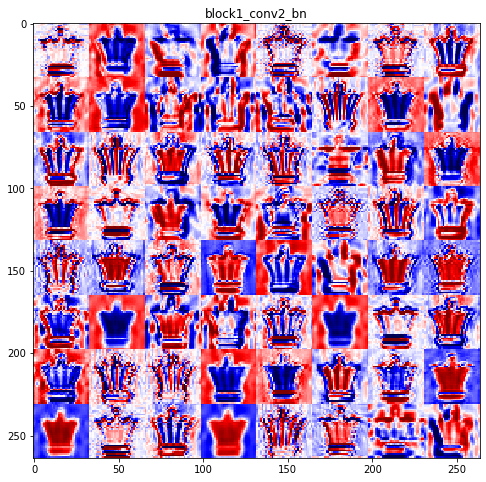

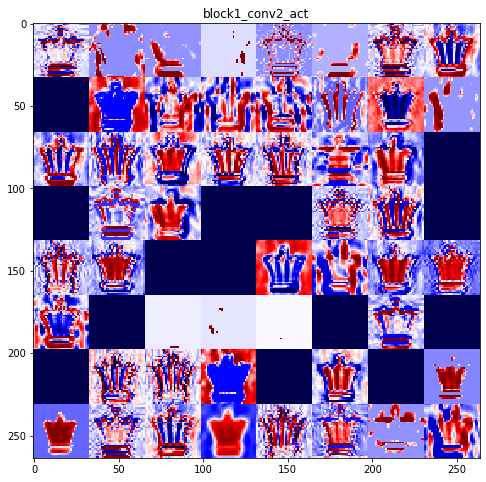

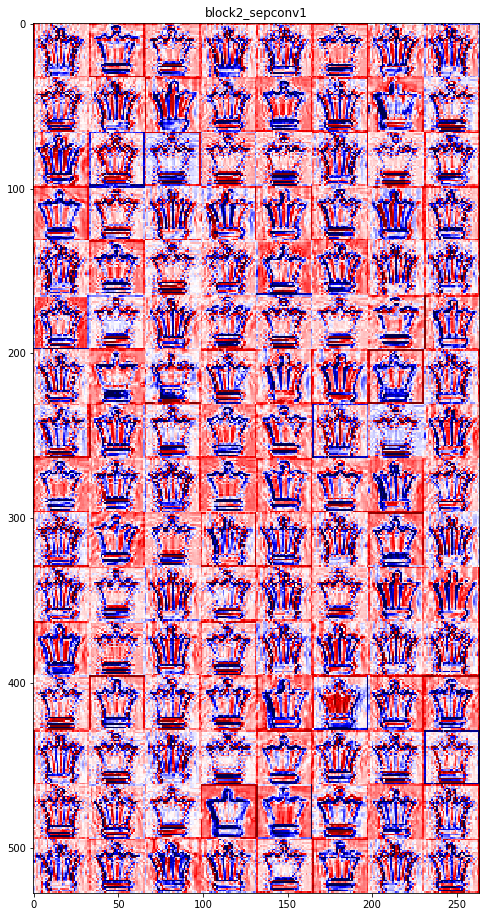

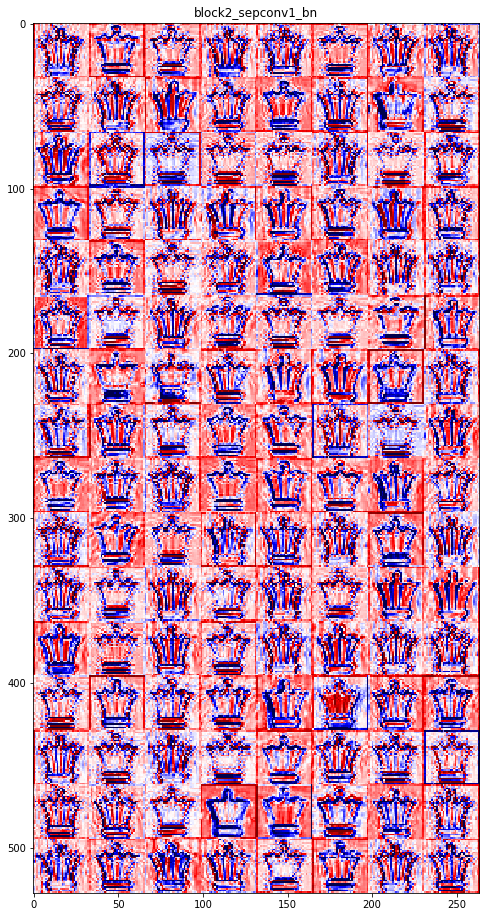

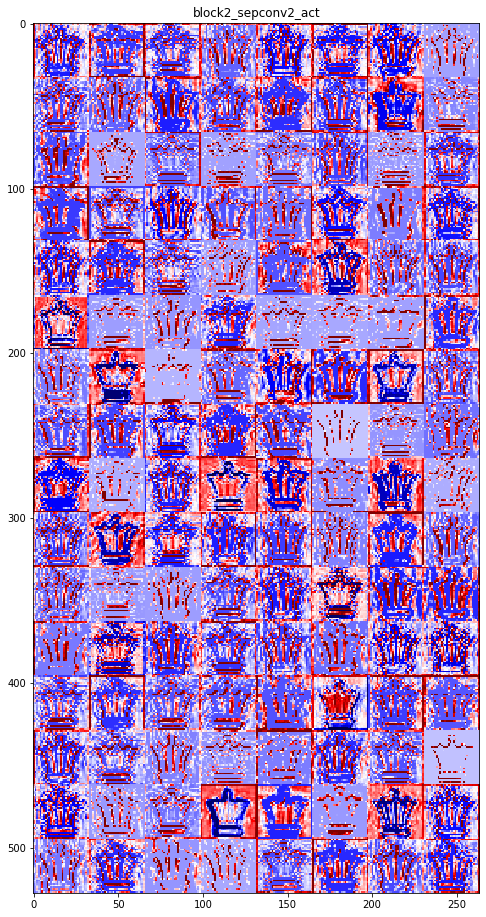

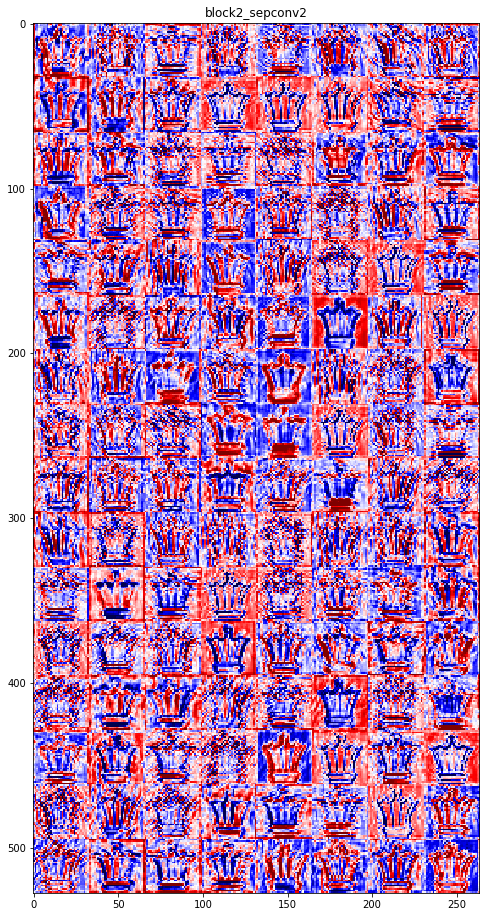

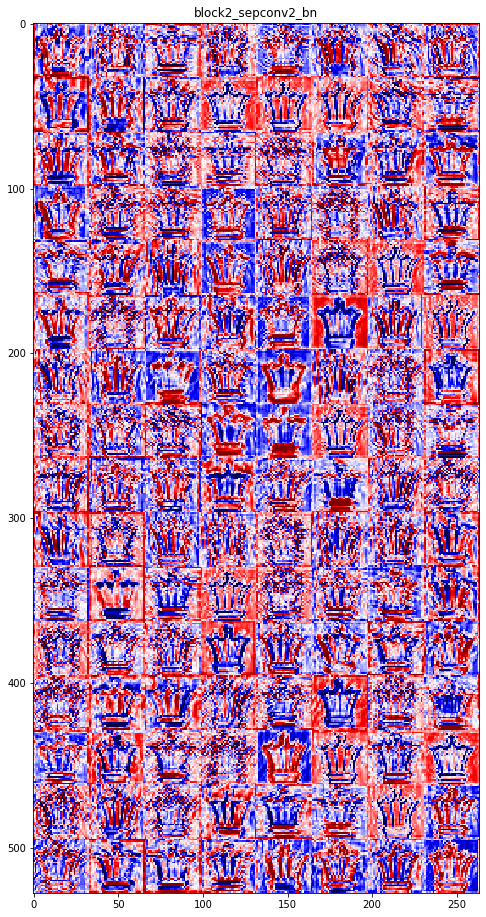

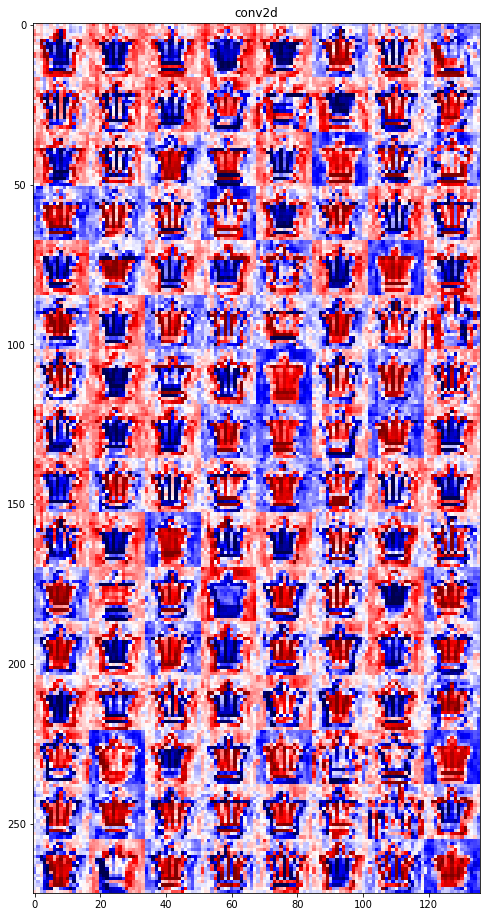

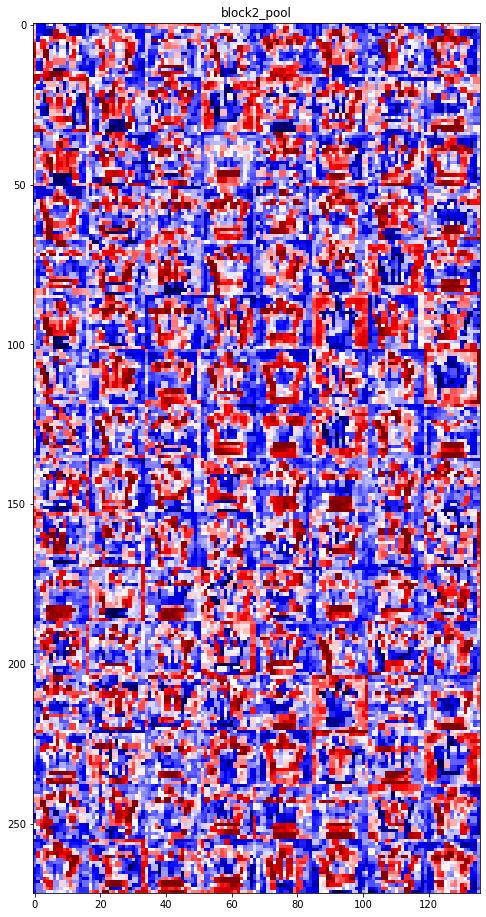

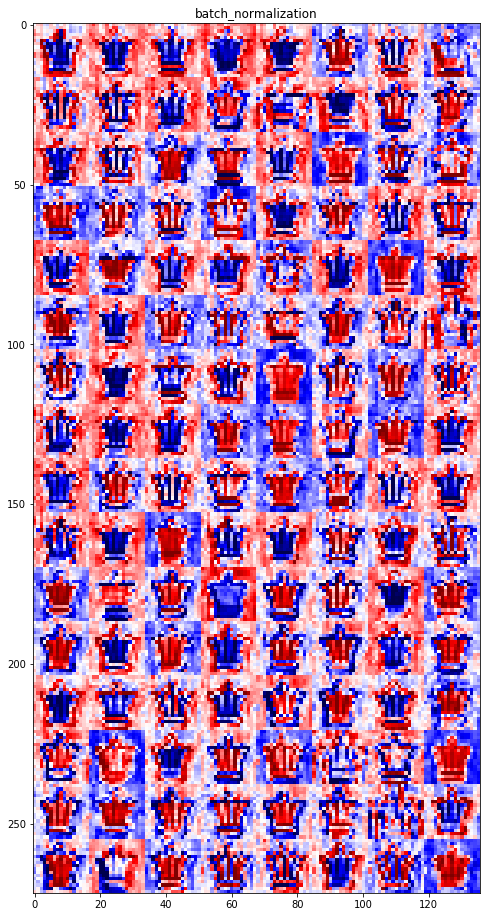

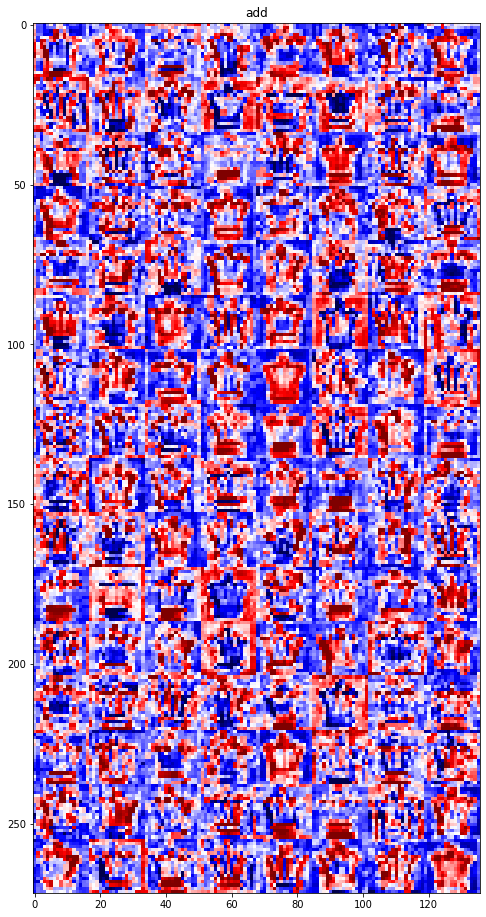

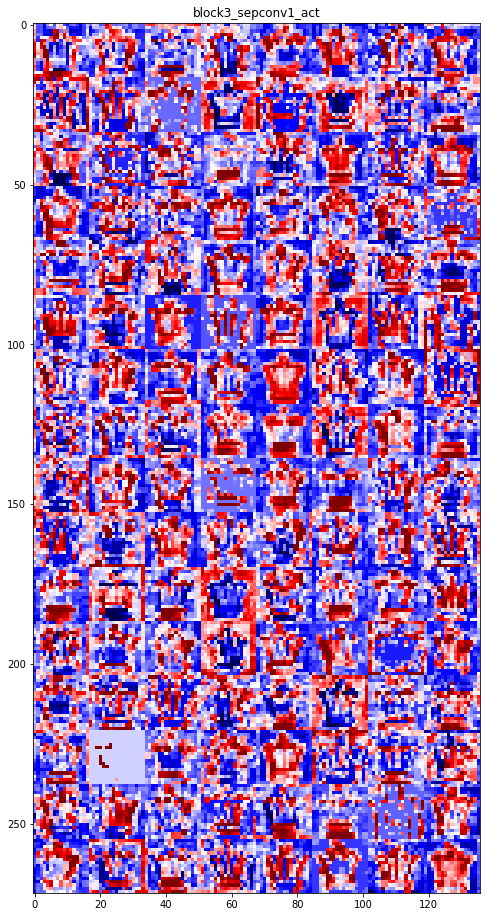

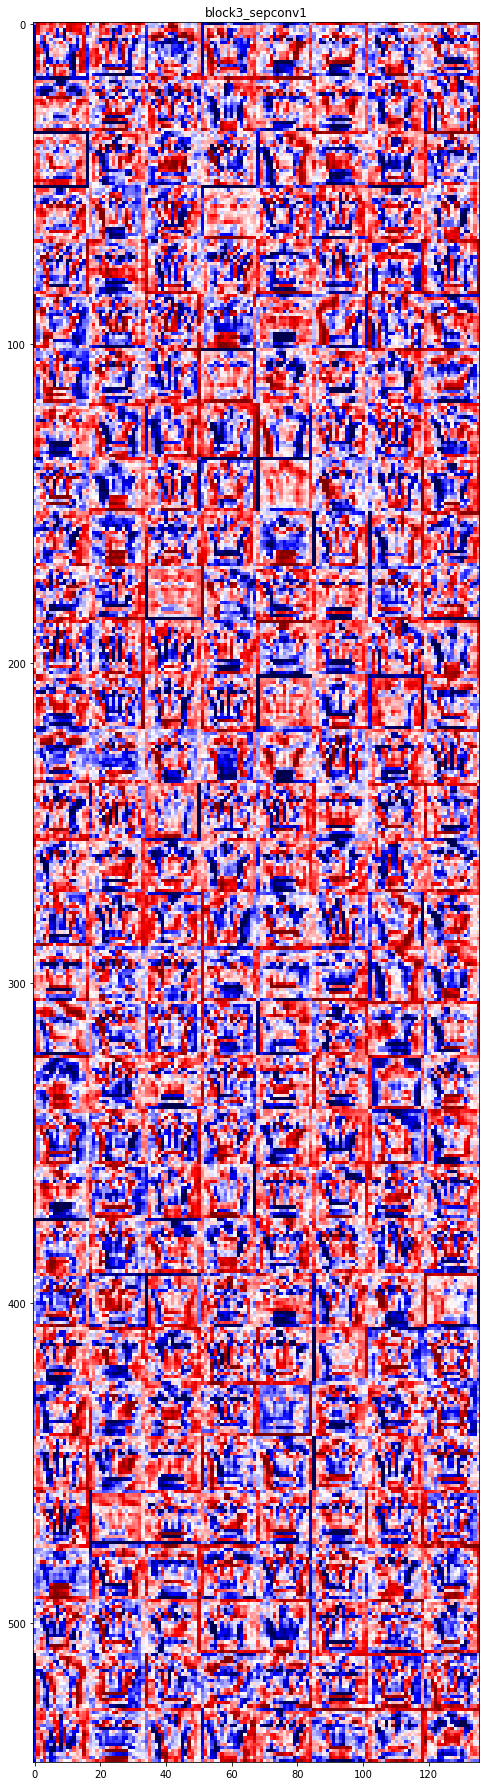

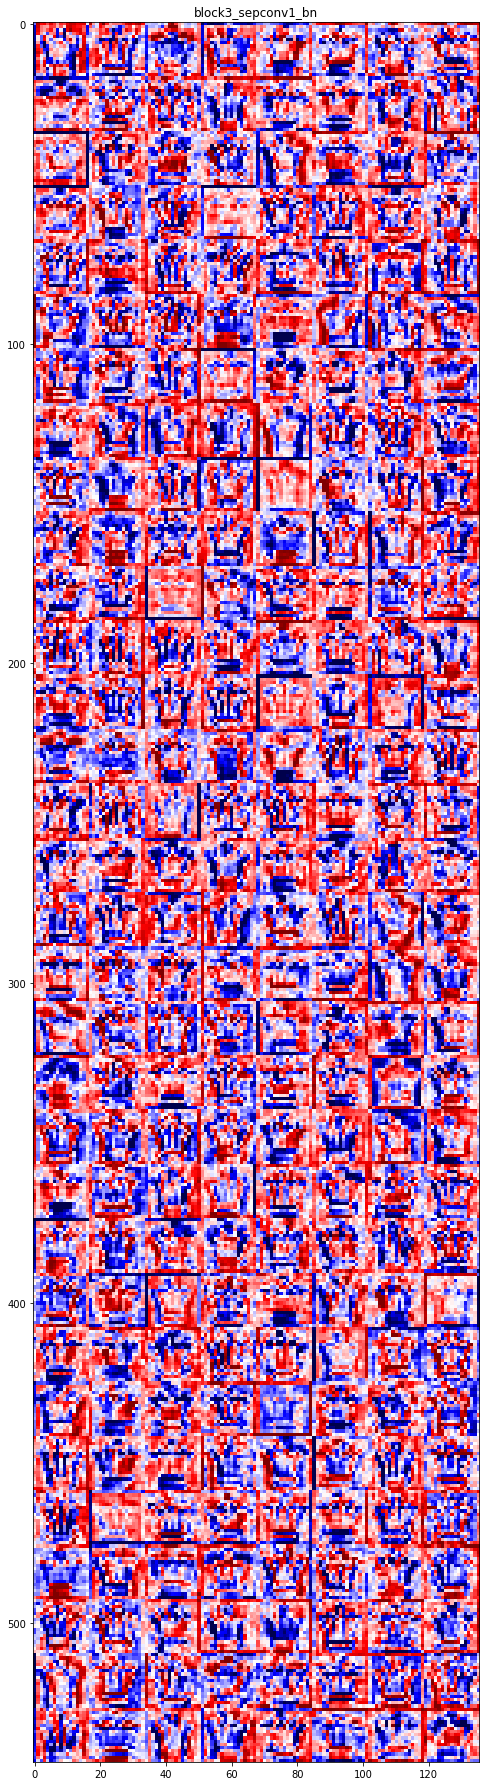

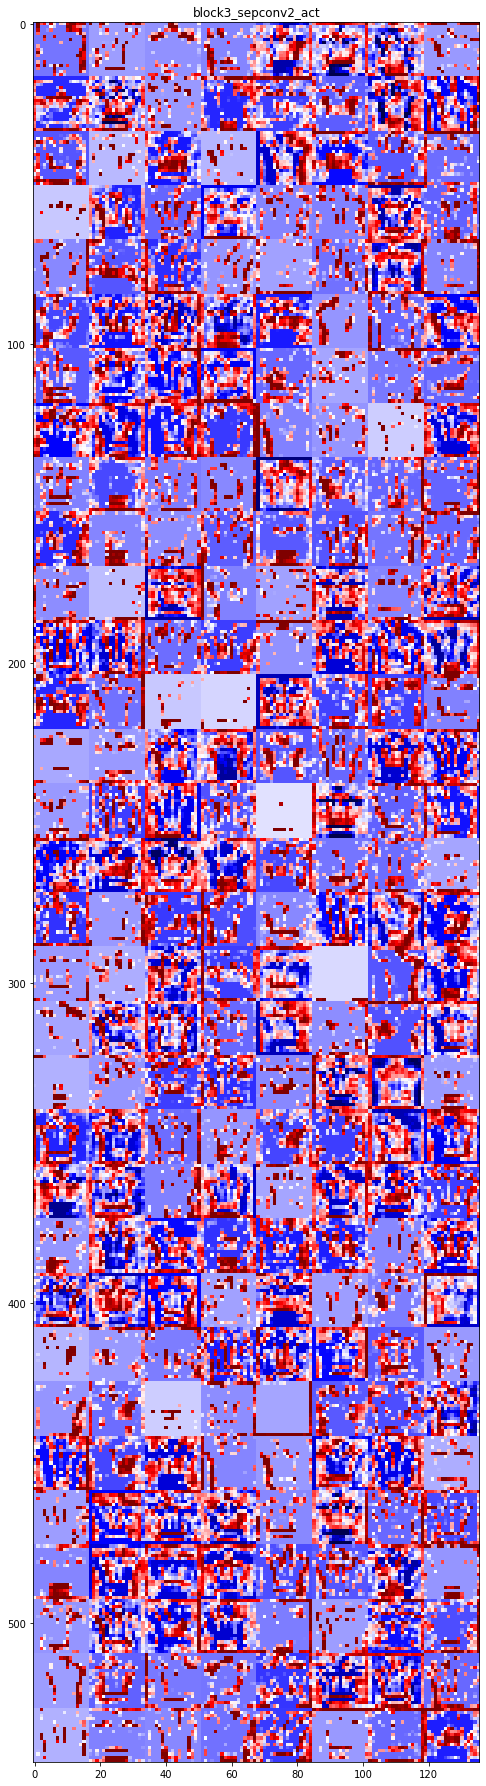

In [167]:
layer_names = []
for layer in model.layers[:20]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 8

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    
    if display_grid.shape[0] > 0:
        h = display_grid.shape[0]
    else:
        h = 100
    
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * h))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='seismic')

## MobileNetV2 model

In [170]:
def make_mobile_net_model(
    n_classes,
    dropout=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.MobileNetV2(include_top=False)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [171]:
mobile_model = make_mobile_net_model(
    n_classes=13,
    dropout=0.3,
    l1=3e-6,
    l2=3e-5,
)

In [172]:
mobile_history = train_model(
    model=mobile_model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=5
)

Epoch 1/5
4000/4000 [==============================] - 376s 94ms/step - loss: 0.3207 - categorical_accuracy: 0.9392 - val_loss: 0.2099 - val_categorical_accuracy: 0.9449
Epoch 2/5
4000/4000 [==============================] - 321s 80ms/step - loss: 0.0846 - categorical_accuracy: 0.9848 - val_loss: 0.0077 - val_categorical_accuracy: 0.9987
Epoch 3/5
4000/4000 [==============================] - 320s 80ms/step - loss: 0.0207 - categorical_accuracy: 0.9949 - val_loss: 0.0047 - val_categorical_accuracy: 0.9996
Epoch 4/5
4000/4000 [==============================] - 321s 80ms/step - loss: 0.0151 - categorical_accuracy: 0.9967 - val_loss: 0.0085 - val_categorical_accuracy: 0.9977
Epoch 5/5
4000/4000 [==============================] - 322s 80ms/step - loss: 0.0121 - categorical_accuracy: 0.9978 - val_loss: 0.0035 - val_categorical_accuracy: 1.0000


In [173]:
best_mn_model_arch_path = str(TEMP_DIR/'best_mn_model.json')
best_mn_model_weights_path = str(TEMP_DIR/'best_mn_model.h5')

In [174]:
mobile_model.save_weights(best_mn_model_weights_path)
with open(best_mn_model_arch_path, "w") as f:
    f.write(mobile_model.to_json())

In [175]:
mobile_preds = mobile_model.predict(test_dataset, steps=test_dataset_length/test_batch_size)

In [178]:
mobile_preds = mobile_preds.argmax(axis=1).reshape(-1,8,8)

In [179]:
fens_from_mobile_predictions = np.array([fen_from_prediction(pred) for pred in mobile_preds])

In [181]:
(fens_from_mobile_predictions == fens_from_file_name).astype(float).mean()

0.99585

## Summary

**Xception** model accuracy after 50 epochs - 0.85595  
**MobileNetV2** model accuracy after 5 epochs - 0.99585